In [1]:
import sys
# insert at 1, 0 is the script path (or '' in REPL)
sys.path.insert(1, '/Users/erio/Dropbox/URP project/Code/PQC_composer')
from BayesOpt import quantum_obj
from QuOTMANN.optimal_transport import circuit_distance_POT
from embedding import qc_embedding
from gate_distance import MUBs

import numpy as np

from qiskit import QuantumCircuit
from qiskit.quantum_info import Operator, Statevector

In [21]:
del quantum_obj

In [18]:
num_qubits = 2
MAX_OP_NODES = 15
num_circuits = 100

encoding_length = (num_qubits + 1) * MAX_OP_NODES
bounds = np.array([[-.2] * encoding_length, [1.0] * encoding_length])

x = bounds[0] + (bounds[1] - bounds[0]) * np.random.rand(num_circuits,encoding_length)
qc_list = [qc_embedding.enc_to_qc(num_qubits=num_qubits, encoding=x[i]) for i in range(len(x))]

In [91]:
qc_list[0].draw()

┌───┐┌────────────────┐┌──────────────┐     ┌───┐     ┌──────────────┐»
q_0: ┤ Y ├┤0               ├┤ Ry(theta[1]) ├──■──┤ Z ├──■──┤ Ry(theta[2]) ├»
     └───┘│  Ryy(theta[0]) │└──────────────┘┌─┴─┐└───┘┌─┴─┐└──────────────┘»
q_1: ─────┤1               ├────────────────┤ Y ├─────┤ X ├────────────────»
          └────────────────┘                └───┘     └───┘                »
«                                    
«q_0: ─■─────────────────────────────
«      │ZZ(theta[3]) ┌──────────────┐
«q_1: ─■─────────────┤ Rz(theta[4]) ├
«                    └──────────────┘

In [5]:
outcome_states = quantum_obj.get_QFT_states(num_qubits, input_states=None)

In [19]:
for idx,qc in enumerate(qc_list):
    if qc.num_parameters == 0:
        print(idx)
        print(qc.draw())

In [20]:
max_fid_QFT = []
for i in range(len(qc_list)):
    opt_param, opt_val = quantum_obj.maximize_QFT_fidelity(qc_list[i], outcome_states=outcome_states)
    max_fid_QFT.append(opt_val)
max_fid_QFT = np.array(max_fid_QFT)

In [21]:
max_fid_QFT

array([0.78284271, 0.74766326, 0.49142136, 0.57320508, 0.6       ,
       0.4618034 , 0.70584248, 0.74380871, 0.4       , 0.78284271,
       0.94026249, 0.83656278, 0.53406527, 0.7       , 0.598386  ,
       0.40055347, 0.88284271, 0.63852772, 0.78284271, 0.51209431,
       0.45668629, 0.62769593, 0.69748737, 0.49142136, 0.54142136,
       0.44356602, 0.4618034 , 0.51919952, 0.78284271, 0.50155858,
       1.        , 0.43887719, 0.54142136, 0.49142136, 0.88284271,
       0.719609  , 0.70077289, 0.54142136, 0.54142136, 0.75801901,
       0.34571068, 0.59142136, 0.54142136, 0.45      , 0.6       ,
       1.        , 0.3       , 0.49142136, 0.58657993, 0.7       ,
       0.69748737, 0.51705436, 0.54142136, 0.5       , 0.78284271,
       0.68612607, 0.7       , 0.4       , 0.52000591, 0.70000006,
       0.88284271, 0.59510818, 0.6       , 0.6       , 0.59138349,
       0.85149405, 0.70386255, 0.69880167, 0.78284271, 0.88284271,
       0.47761519, 0.70651422, 0.4618034 , 0.6       , 0.54142

In [11]:
varform = qc_list[-2]
U = Operator(varform.bind_parameters(opt_x))

input_states = [Statevector(state) for state in MUBs.get_anchor_states(varform.num_qubits)]
output_states = [state.evolve(U) for state in input_states]

observables = [state.to_operator() for state in outcome_states]

fid = 0
for idx, state in enumerate(output_states):
    # fid += state.data.conj() @ observables[idx].data @ state.data
    #fid += np.trace(observables[idx].data @ state.to_operator().data)
    fid += state.expectation_value(observables[idx])
print(np.real(fid / len(input_states)))
#return np.real(-fid / len(input_states))

0.5414213562344331


In [86]:
varform.draw()

┌──────────────┐                     ┌───┐      »
q_0: ───────────────────────┤ Rz(theta[1]) ├───────■─────────────┤ H ├──────»
                            └──────┬───────┘┌──────┴───────┐┌────┴───┴─────┐»
q_1: ──────────────────────────────┼────────┤ Ry(theta[3]) ├┤ Rx(theta[6]) ├»
     ┌────────────────┐            │        └────┬───┬─────┘└──────────────┘»
q_2: ┤0               ├──■─────────■─────────────┤ H ├──────────────────────»
     │  Ryy(theta[0]) │┌─┴─┐┌──────────────┐     └───┘                      »
q_3: ┤1               ├┤ X ├┤ Ry(theta[2]) ├────────────────────────────────»
     └────────────────┘└───┘└──────────────┘                                »
«     ┌────────────────┐                ┌────────────────┐┌────────────────┐»
«q_0: ┤0               ├────────────────┤0               ├┤1               ├»
«     │                │     ┌───┐      │                ││                │»
«q_1: ┤  Ryy(theta[4]) ├─────┤ X ├──────┤  Rxx(theta[7]) ├┤  Ryy(theta[9]) ├»
«     │                │┌────┴───┴─────┐│                ││                │»
«q_2: ┤1               ├┤ Rx(theta[5]) ├┤1               ├┤0               ├»
«     └────────────────┘└──────┬───────┘└┬──────────────┬┘└────────────────┘»
«q_3: ─────────────────────────■─────────┤ Rx(theta[8]) ├───────────────────»
«                                        └──────────────┘                   »
«     ┌───────────────┐                                                      »
«q_0: ┤ Ry(theta[11]) ├──────────────────────────────────────────────────────»
«     ├───────────────┤                                                      »
«q_1: ┤ Rz(theta[10]) ├──────────────────────────────────────────────────────»
«     └───────┬───────┘┌───┐                                                 »
«q_2: ────────■────────┤ Y ├─■────────────────────────────────■──────────────»
«                      └───┘ │ZZ(theta[12]) ┌───────────────┐ │ZZ(theta[14]) »
«q_3: ───────────────────────■──────────────┤ Rx(theta[13]) ├─■──────────────»
«                                           └───────────────┘                »
«                                     
«q_0: ────────────────────────────────
«        ┌─────────────────┐          
«q_1: ─■─┤0                ├──────────
«      │ │  Ryy(theta[15]) │┌───┐┌───┐
«q_2: ─■─┤1                ├┤ Y ├┤ H ├
«        └─────────────────┘└───┘└───┘
«q_3: ────────────────────────────────
«

In [22]:
dist_mat = np.zeros(shape=(len(x),len(x)))
distnorm_mat = np.zeros(shape=(len(x),len(x)))

for i in range(len(qc_list)):
    for j in range(i+1,len(qc_list)):
        res = circuit_distance_POT(qc_list[i], qc_list[j])
        print(res)
        dist_mat[i,j] = res[0][0]
        distnorm_mat[i,j] = res[1][0]

([34.15757865245923], [0.19905348865069486])
([62.92762001962011], [0.47672439408803113])
([42.08783149408089], [0.26028343533754417])
([26.20158462070142], [0.14703470606454222])
([56.1624858817609], [0.3867939799019346])
([78.01043030935816], [0.3238291004954677])
([55.085414900091365], [0.37094555488277015])
([33.58982496955934], [0.18506790616837102])
([57.32396929768614], [0.38601999527061376])
([52.424378035726974], [0.2647695860390252])
([51.12654697902683], [0.23835220036842344])
([44.511781092072496], [0.26447879436763216])
([35.36247235385124], [0.20218680591109917])
([36.46503267517073], [0.20462981299197944])
([46.49045590664262], [0.30626123785667075])
([79.78091578199167], [0.3223471344726936])
([58.8998568644678], [0.28330859482668497])
([41.0945570316719], [0.20754826783672675])
([46.0845626807631], [0.2327503165695106])
([28.16074487474658], [0.15802887135099092])
([34.028215955159155], [0.18748328349949947])
([36.13347202437782], [0.18558537249295232])
([39.9509749831

([38.18515362779881], [0.2755061589307274])
([37.69094393464048], [0.23309179922474016])
([25.07644367310568], [0.16519396359094649])
([39.35746660339382], [0.29816262578328656])
([50.199900418825706], [0.2668787901053999])
([31.759243202366118], [0.21872757026422948])
([67.88291483767125], [0.7093303535806819])
([32.79080123009977], [0.2160131833339906])
([34.81950044366483], [0.20688948570210833])
([74.82923643006505], [0.35430509673326255])
([34.47751533855377], [0.2089546384154774])
([58.120521955294016], [0.30898735755073914])
([33.60889775407413], [0.22632254379847896])
([47.696161575985975], [0.43798128168949474])
([61.8653722095633], [0.4933442759933277])
([32.888717536321636], [0.35593850147534234])
([114.99860311408302], [0.611369500872318])
([32.54334711188586], [0.34005587368741746])
([65.4752731672342], [0.5087433812527911])
([35.658592842963074], [0.37260807568404464])
([71.93170596815726], [0.49539742402312165])
([92.10918255928377], [0.569630071485985])
([52.98898799550

([27.014079031973036], [0.20989960397803448])
([39.130733973709376], [0.34875876981915666])
([33.35653928343522], [0.29729535903239945])
([60.19519971556446], [0.3377957335329095])
([16.623444207752392], [0.1171490078065708])
([69.05287968957064], [0.35466296707535])
([71.33883464471], [0.3727211841416406])
([68.80527459205008], [0.3594841932708991])
([28.40461162745795], [0.22070405304940133])
([36.27871964868088], [0.23899024801502555])
([30.414364112005067], [0.2143366040310435])
([31.451641481598532], [0.2575892013234934])
([54.64505289581834], [0.30665012848382905])
([20.65420005383455], [0.15265484149175576])
([54.75469549358633], [0.6381666141443629])
([15.036414656091482], [0.10596486720289983])
([33.4947979288039], [0.21145705763133776])
([85.13237900905857], [0.4229129608000923])
([37.013809027583015], [0.23864480353051595])
([52.70283998216977], [0.2957510661176755])
([19.54364600444118], [0.14100754692959008])
([53.563686152762955], [0.3864623820545668])
([85.15830141992033

([64.36559309420528], [0.414994152767281])
([33.262572723205324], [0.27242074302379465])
([24.97037349867987], [0.229296359032873])
([66.90527869751601], [0.41376177302112566])
([61.69457431383814], [0.39777288403506217])
([26.207220088227793], [0.233575936615221])
([24.637366443022668], [0.2574437454861303])
([23.768662454554356], [0.24836637883546875])
([74.90171054046223], [0.46321404168498603])
([28.294051463166102], [0.2256303944431109])
([84.51284971683286], [0.47425841591937634])
([82.32090741506731], [0.4706741418814598])
([77.37852381169755], [0.4424158022395514])
([21.41674976421666], [0.19088012267572782])
([39.9108976911971], [0.2949807663798751])
([40.632190111116046], [0.3240206547935889])
([26.451296972108494], [0.2504857667813305])
([66.39692686175148], [0.41061797688158])
([26.593292661377056], [0.2238492648264062])
([37.71306818181819], [0.5442001180637546])
([26.016826285420596], [0.2074707040304673])
([47.48000839221934], [0.33460189141803626])
([94.9673314669309], 

([72.9591847106598], [0.4421768770343018])
([65.98589894662125], [0.4165776448650331])
([19.959358088516606], [0.1728082951386719])
([31.383067837293346], [0.3170006852251853])
([31.91180707560454], [0.3223414856121671])
([64.0044610306789], [0.38790582442835697])
([37.06371295954117], [0.2879853376809726])
([88.02445373564787], [0.4849832161743684])
([86.18163714786233], [0.4836231040845249])
([86.69112888039349], [0.48648220471601283])
([24.49314734039764], [0.21206188173504448])
([44.875749636588196], [0.3237788574068412])
([38.25266664406096], [0.29722351704787064])
([20.576867927206564], [0.1889519552544221])
([69.60642604337504], [0.4218571275356063])
([34.65634581255111], [0.2838357560405496])
([46.922491375475744], [0.6463153082021451])
([36.30524277724163], [0.282092018471186])
([53.4498838138577], [0.36811214747835885])
([96.54469220719662], [0.5132625848335811])
([56.60691337382405], [0.39892116542511663])
([73.52294452830435], [0.44559360320184455])
([40.17326618901855], [0

([30.541955773040648], [0.23731123366775952])
([83.11431643493664], [0.45793011809882445])
([78.9553302388826], [0.4430714379286341])
([77.53564229746641], [0.4351046144638968])
([18.843376668359795], [0.16314611834077744])
([42.99799884223129], [0.31023087187757065])
([38.581499135134926], [0.2997785480585465])
([20.623530445704255], [0.1893804448641346])
([63.21270841855746], [0.3831073237488331])
([21.753976292414983], [0.1781652440001227])
([43.194802735080884], [0.5949697346429874])
([23.844000755588365], [0.18526807113899274])
([51.43783363457878], [0.3542550525797437])
([97.70627768751197], [0.5194379462387665])
([52.17512948200593], [0.36768942552505945])
([61.793912872721954], [0.3745085628649815])
([34.290512787860024], [0.2734490652939396])
([53.00087725133957], [0.23276625933833806])
([57.644549899946504], [0.3176008258950221])
([56.771546556454915], [0.30181577116669284])
([47.30591538884622], [0.24715734267944742])
([65.13697362342522], [0.39476953711166807])
([86.6479745

([43.02190177576791], [0.1862419990292983])
([71.37556446506144], [0.3794554198036228])
([106.58196680071599], [0.7689896594568254])
([62.91540142372211], [0.3231402230288758])
([51.276328727563296], [0.24278564738429592])
([48.18921706274008], [0.18964666297811916])
([66.94234624077663], [0.321993007411143])
([48.026903033001695], [0.20790867113853548])
([73.19572738137003], [0.382422818084483])
([37.34691603742459], [0.2357759850847512])
([35.727869688774234], [0.22095157506972318])
([37.24458669471446], [0.27527410713018813])
([97.79050652310993], [0.4233355260740689])
([65.28265183465751], [0.3410796856565178])
([48.677535614173195], [0.2681957885078413])
([53.153576719095796], [0.29285717200603745])
([32.37176157914981], [0.2001964228766222])
([34.01959144856443], [0.20617934211251168])
([40.55050876643078], [0.22755616591712])
([47.54865472434276], [0.2668274675889044])
([33.49718551607441], [0.23606191343251873])
([38.3484267877198], [0.24209865396287752])
([28.025662629879648],

([30.895577330897247], [0.18004415693996065])
([36.18528458431239], [0.2068912783551309])
([43.44061739271504], [0.23094427109364726])
([37.71159980843884], [0.2004869739948902])
([39.182330894974804], [0.2581181218377787])
([31.479666979446115], [0.18704496125636433])
([38.86275116986566], [0.24534565132490951])
([45.121044786020995], [0.23987796271143544])
([36.36789661235912], [0.2079353722833569])
([39.066331869550545], [0.23212318401396642])
([54.416784650378375], [0.2703267990580148])
([34.21048629973691], [0.22057051128134691])
([46.17722255073767], [0.3331689938725662])
([50.959480527103906], [0.36767301967607446])
([53.57030631666297], [0.27055710260940896])
([35.73988500564256], [0.20056052191718612])
([79.48075005491879], [0.35419229079732084])
([41.70175624845902], [0.2688701241035398])
([40.6997363203282], [0.26240964745537204])
([27.744246800948755], [0.1616797599122888])
([50.30962980188712], [0.36298434200495766])
([29.68001740472335], [0.19136052485314867])
([49.869101

([102.33382383396804], [0.42479794036516405])
([120.83951167793543], [0.5812386324095018])
([112.52670634666514], [0.5014559106357626])
([77.05132834821974], [0.29555553643352406])
([136.44382093244138], [0.7383323643530377])
([99.45908079612603], [0.43679877380819515])
([87.44359800356781], [0.3441306493646903])
([128.23553393899311], [0.658631401843827])
([122.4786055145546], [0.5986246603839422])
([97.07848728498142], [0.43261357970134323])
([108.76919336585289], [0.4847112003825885])
([100.28224651356548], [0.4280078809797929])
([100.32922590511873], [0.4470999371885861])
([91.31410716673454], [0.35026508310983706])
([88.22324360128681], [0.3662235101755368])
([67.83343535438574], [0.24470936275030927])
([63.9276121733554], [0.2333976348059708])
([89.59425546410068], [0.3770801997647335])
([113.58515557984133], [0.529534524847745])
([98.45028875693619], [0.426191726220503])
([86.55046157610334], [0.3544244945786377])
([101.43934958303255], [0.43294643441328445])
([131.0252875564457

([76.47949667887602], [0.5150134456489968])
([27.78137427505848], [0.13154059789326933])
([68.68935606012293], [0.4524990517794659])
([52.49204392300065], [0.31189568581699734])
([38.520678083212076], [0.17166077577188982])
([41.37496389138538], [0.20896446409790595])
([35.92111217012828], [0.17008102353280438])
([67.39831078926169], [0.27231640722934014])
([44.56016284768566], [0.22886575679345483])
([44.703591146010766], [0.21502448843680025])
([55.01234164218157], [0.29246327295152347])
([86.64465734990485], [0.6403891895780106])
([26.548646072811742], [0.13408407107480677])
([28.911342823760133], [0.13906369804598429])
([54.557556103276255], [0.31193571242582196])
([66.05769749110753], [0.408520083432947])
([32.15116977692655], [0.14988890338893496])
([35.153741523304035], [0.16908966581675822])
([65.38794248980423], [0.3962905605442681])
([72.66644908403849], [0.48933635746827264])
([70.28655607958947], [0.47331014195009746])
([40.11433610508624], [0.18701322193513398])
([43.90335

([30.71704155842196], [0.18251361591456897])
([38.319515384332774], [0.24191613247684826])
([49.223225939503735], [0.35514593029944974])
([51.07773824512427], [0.2623407203139408])
([33.596778435669286], [0.2213226510913655])
([70.06070800960697], [0.6848554057635089])
([35.74796719132396], [0.22568161105633816])
([20.76563602201417], [0.11872862219562133])
([66.90763826434161], [0.3071976045194748])
([32.94543743155338], [0.19198972862210592])
([55.15484111814485], [0.2832811562308416])
([39.3046837027508], [0.2534151109139316])
([40.603678861184896], [0.2121404329215512])
([42.82388185404891], [0.22374023957183342])
([47.67989739808181], [0.30741390972328697])
([36.76799084974146], [0.21426568094254927])
([40.97172160724051], [0.2533810860064348])
([40.393579388567595], [0.2110427345275214])
([33.34674235255503], [0.1871309896327443])
([37.103174122614725], [0.2162189634185007])
([48.2174646149992], [0.23566698247800194])
([44.68336410609117], [0.2820919451142119])
([48.6185131464809

([43.27099983695989], [0.20813371734949443])
([84.26315463118125], [0.6383572320544035])
([53.65622435728486], [0.3067823004990559])
([37.66293950272577], [0.18709855689381907])
([75.78404589186229], [0.534066567243568])
([66.64374049343307], [0.43902332340864997])
([49.782316705584236], [0.29010674070853293])
([51.39573534005393], [0.2995089472031115])
([47.88281284155774], [0.2638171506421914])
([46.9165127846494], [0.27340625165879606])
([40.41249001483122], [0.19438427135560954])
([37.78758647317932], [0.20089094350440895])
([53.09203181314925], [0.23659550718872216])
([31.863488014174166], [0.14411346908265116])
([46.13693505057182], [0.24965873945114625])
([62.22712926999002], [0.38483073141614116])
([47.330232519689254], [0.26560175375807665])
([40.08866208342414], [0.2094496451589558])
([55.08395182258508], [0.3034928475073558])
([73.50572372631294], [0.5062377667101442])
([38.50167398427019], [0.18519323705757673])
([75.00774620245875], [0.5051026680300253])
([64.4543633165922

([49.49724657040386], [0.2678422433463412])
([44.87878913773365], [0.31627053655908144])
([51.66503186761243], [0.41200184902402254])
([57.514421706368026], [0.4586477010077195])
([60.380686476433844], [0.3154685813815771])
([37.82243127012813], [0.2438583576410582])
([66.42919636325584], [0.31952475403201464])
([67.02936629559368], [0.3276117609755312])
([64.43153718990575], [0.3149146490220222])
([37.50458849702015], [0.26430294923904263])
([25.915781316004754], [0.15706534130911973])
([41.67433384776034], [0.2686933194568687])
([51.42990049859752], [0.3801175203148376])
([55.32481959269566], [0.2890533939012313])
([40.02573596160629], [0.26953357549903223])
([67.69366637144452], [0.6837744077923689])
([31.32845474150875], [0.20198874752745813])
([37.87484098742741], [0.22071585657008982])
([75.38690065458854], [0.3514540823057741])
([36.77374603065496], [0.21850116476919168])
([47.737480444933155], [0.24941212353674588])
([37.79521787962031], [0.2489803549382102])
([46.5235029356577

([55.31917108008042], [0.39912821847099866])
([37.240966908312075], [0.23510711432015202])
([38.84150447089537], [0.24521151812433947])
([40.46449877784706], [0.24043077111020242])
([44.45007448249093], [0.2806191570864327])
([52.19893746918349], [0.26809931930756803])
([35.29131456506427], [0.20177995749036176])
([62.475957814775725], [0.2958141941987487])
([60.49216474957604], [0.2909676034130642])
([34.1700274109651], [0.19912603386343297])
([52.89093391868953], [0.35616790517636043])
([39.512869750486296], [0.23947193788173513])
([35.76244756400389], [0.2006871356004708])
([38.01907853846263], [0.22590064491065137])
([63.04993433912455], [0.4776510177206405])
([46.617717037429664], [0.2394335749225972])
([58.596863080001434], [0.43308841892092714])
([45.48645157447599], [0.2996472435736231])
([48.38592334955425], [0.23273652404788])
([36.79646658571168], [0.20273535308932053])
([42.861009310798735], [0.2201387227056946])
([80.20258176040731], [0.34719732363812694])
([22.89145712900

([99.757920843189], [0.7557418245696136])
([55.52404139028271], [0.29518363312218354])
([50.696996674639976], [0.24778590750068416])
([46.72697206275625], [0.1887958467182071])
([49.19160097387244], [0.244369602453415])
([33.06035646694272], [0.147327791742169])
([60.25445102991136], [0.32605222418783203])
([32.9155020088002], [0.2695782310303047])
([31.724097754326525], [0.25982062042855464])
([59.100136410624266], [0.32562058628443125])
([44.866207667115745], [0.27746572459564467])
([97.18240394744602], [0.4674478304350458])
([30.626713065349556], [0.22097195573845274])
([29.515355395581786], [0.21295350213262468])
([34.66236537849907], [0.22348398051901394])
([32.64432593964446], [0.2673572968029849])
([23.206596111781995], [0.16743575838226543])
([60.67560280314019], [0.34691596799965796])
([48.60099027837248], [0.49091909372093406])
([32.14004487105785], [0.2264978496903302])
([61.415457861943125], [0.36491656483626334])
([40.748235598189204], [0.3741803085233168])
([37.9757475078

([66.73548770310487], [0.4302739374797219])
([27.659476136373982], [0.24651939515484836])
([26.80570068849866], [0.28010136560604665])
([23.28880173535305], [0.24335216024402354])
([74.39379537957018], [0.4600729460703165])
([40.474686221731375], [0.3227646429165182])
([86.41870284031768], [0.4849534390590218])
([89.11073222722356], [0.509495324340901])
([81.64430025079751], [0.46680560463577764])
([22.837766971474863], [0.20354516017357274])
([44.280432914656316], [0.32727592693759283])
([39.428018613671], [0.31441801127329344])
([20.546349019911883], [0.1945676990521959])
([77.07278190759841], [0.4766405807520001])
([33.32976853715728], [0.2805536072151286])
([41.09218529430396], [0.592960826757633])
([40.6888388215955], [0.3244723988962959])
([47.71482340534284], [0.3362566836176381])
([94.09151492778835], [0.509153219306214])
([50.68044755924038], [0.36565979479971417])
([68.97692714186938], [0.4265734517122411])
([33.71309211334658], [0.27611050051880903])
([50.98647537355877], [0

([120.69114853067892], [0.7171191237711165])
([79.93858730006535], [0.34605449047647335])
([72.35759871487431], [0.3003636310289511])
([88.89133067485616], [0.4275677281137863])
([97.74345722260934], [0.5020208383287588])
([56.69245081669463], [0.22906040734018032])
([67.86060896076441], [0.28169617667399094])
([93.60104706932941], [0.47273256095620914])
([105.49615611055115], [0.5812460391765903])
([109.98195507824516], [0.6059611850041056])
([64.67218665912051], [0.2613017642792748])
([87.29245641167415], [0.4133165549795178])
([47.80339333951338], [0.18107345961936885])
([51.32235064810554], [0.19686363884965685])
([60.11208386214739], [0.23057953150037358])
([94.83303111055116], [0.4789547025785412])
([86.82980185113604], [0.39271733085090926])
([83.51804481641516], [0.3954452879565112])
([98.59714285714284], [0.5151365875503806])
([60.49771159041033], [0.24443519834509225])
([89.23288690058244], [0.43613336706052025])
([125.43181818181819], [0.8087157845378349])
([84.0397463699884

([47.99828354416988], [0.2551742878477931])
([39.55329108260504], [0.2550179953746296])
([43.85464315403481], [0.3090531582384412])
([53.967627812397524], [0.2771835018613124])
([42.026410769798346], [0.22342589457628043])
([47.53502869352858], [0.3273762306716845])
([62.24144622898176], [0.4836165208157091])
([57.25742294669471], [0.44489062118643913])
([49.429488617004104], [0.2538751341397232])
([44.32086944294798], [0.27980346870547973])
([65.72419831145689], [0.311194120792883])
([71.18975073446039], [0.342423043455798])
([66.3227563898563], [0.319012777247986])
([46.40873856719487], [0.3196194116197994])
([27.538900222903962], [0.16362982901309542])
([42.72716059428601], [0.26974217546897733])
([54.54510165007858], [0.393543301948619])
([59.5943593619124], [0.3060829962091033])
([47.30996807521994], [0.31165986874321433])
([76.45795454545454], [0.7473895849995557])
([42.91320121913224], [0.27091667436320865])
([33.39681043138394], [0.19094802991071438])
([75.83820513425994], [0.3

([53.42475619601446], [0.23462782694780177])
([53.48711473177622], [0.23490168964328595])
([67.6687509705972], [0.41011364224604363])
([53.71667194688124], [0.28557507680425964])
([50.1460673631936], [0.28140329608975084])
([65.1944026091152], [0.411580824552495])
([33.19650228892787], [0.15476224843323014])
([59.07848383949075], [0.3442802088548412])
([93.30096910652543], [0.7641357011181443])
([52.771872677838516], [0.2961384549822588])
([47.51521476674421], [0.2440432191409564])
([55.45209665481697], [0.2333842451802061])
([45.917329821211716], [0.23990245465627855])
([37.19677548246891], [0.17341154071081075])
([53.947129165047954], [0.3084455641226298])
([53.925175858899095], [0.5271278187575671])
([80.82890065967317], [0.6280411861668467])
([16.568978399704577], [0.23909059739833444])
([35.08929090095782], [0.44304660228482085])
([49.8330104881671], [0.5033637423047183])
([50.53567825195725], [0.5104613964844166])
([60.90845468263344], [0.5593062872601786])
([50.68896103067891], 

([75.40296181369999], [0.5193041447224518])
([57.36763419223245], [0.4574771466685204])
([91.18524611797497], [0.5639161788371984])
([87.77587895471613], [0.5541406499666424])
([58.223875102105474], [0.4768540139402578])
([32.56038607746576], [0.32889278866127025])
([44.23025725879918], [0.3829459502926336])
([61.52226907447863], [0.4780285087372077])
([46.174266035651435], [0.388672273027369])
([20.882628938776694], [0.2531227750154751])
([78.90192191385134], [0.5434016660733565])
([18.337819922235056], [0.21372750492115455])
([33.59544984266065], [0.3284012692342195])
([90.29950923634443], [0.5700726593203563])
([63.53331107770458], [0.4813129627098832])
([82.92747167582192], [0.5711258379877543])
([112.63335523637927], [0.6205694503381779])
([62.4114051646743], [0.4849371030666224])
([78.77557393143992], [0.5551485125541926])
([58.6662716845991], [0.48047724557411225])
([21.285163091358875], [0.3071452105535191])
([60.214498754452414], [0.456170445109488])
([75.03274320069305], [0.5

([71.82163111277693], [0.3752436317281971])
([75.1855491693593], [0.39281896117742576])
([28.855018106377006], [0.2242037148902642])
([41.8118416878135], [0.2754403273241996])
([20.785566865043148], [0.14648038664582905])
([33.66673728089077], [0.2757308540613495])
([59.87329468688396], [0.33598930800720517])
([26.79362667147562], [0.198031239257026])
([57.14834436962147], [0.6660646196925578])
([29.98587830602518], [0.21131697185359538])
([41.39909232243238], [0.261357906075962])
([79.98709203335063], [0.3973526678258849])
([44.593355117633344], [0.28751357264753924])
([66.70877116065853], [0.374347761844324])
([24.581186629802488], [0.1773534388874638])
([38.274056146532885], [0.2577377518285043])
([54.98147129565635], [0.2975187840674045])
([30.298481628668473], [0.18362716138586957])
([63.129732962224836], [0.31361019852073935])
([59.655566100514946], [0.30129073788138866])
([32.07374737509692], [0.19835341604883688])
([34.79021382896828], [0.2510116437876499])
([32.15383627328055]

([47.503129438169964], [0.32715653883037166])
([57.585482728378736], [0.44743964823915106])
([55.27722655835156], [0.4295044798628715])
([49.7116365844597], [0.25532427624273085])
([39.48282224232581], [0.24926024142882458])
([64.62465459234534], [0.305987947880423])
([70.19765882284071], [0.33765107658894045])
([59.32828068327848], [0.28536931545588495])
([42.90426370169377], [0.2954839097912794])
([25.970978566642], [0.15431359813809864])
([38.859929136433905], [0.2453278354572848])
([52.443401661021674], [0.3783795213637928])
([47.78427422287892], [0.24542513725156098])
([40.512500356282985], [0.26688076651042814])
([71.54675614322227], [0.6993817804811562])
([37.61966450303214], [0.2374978819635868])
([34.53657227453578], [0.19746467852793473])
([69.0637714570117], [0.3170972059550583])
([29.70258844220345], [0.17309200723894788])
([50.7785125604126], [0.26080386523067595])
([32.407346588022456], [0.20894485227609583])
([29.136322556282533], [0.12094778977286233])
([62.944878274869

([22.110977467917888], [0.19706753536468707])
([68.22918744316559], [0.4054021832630159])
([21.246059055815582], [0.16942630826009236])
([44.371097036721615], [0.5845994339489013])
([35.062040823521336], [0.26562152139031314])
([53.90556924649728], [0.363000466306379])
([92.19759296953224], [0.48170111269348087])
([49.80192062160016], [0.342988434033059])
([69.06311529493743], [0.4103571912949342])
([31.398309313810746], [0.24396510733341684])
([32.55384753233624], [0.19729604565052267])
([24.047013807106232], [0.1550419974668358])
([50.027614175848534], [0.42110786343306855])
([48.858819685547665], [0.26919459881844454])
([39.24346020567426], [0.3214042604887327])
([26.13223176311828], [0.18854424071513912])
([60.02151407386699], [0.3082769084430765])
([36.778772166285165], [0.21853102891435033])
([57.32627924228933], [0.3158472685525583])
([83.97218886416037], [0.3855472399640055])
([36.85770884781163], [0.2233800536231008])
([58.05062650883872], [0.32576109151985816])
([38.353213230

([66.10894036038772], [0.40066024460841054])
([71.93427822606978], [0.48440591398026794])
([70.32458224531544], [0.47356621040616464])
([40.57291043474384], [0.18915109759787344])
([51.5483986926998], [0.28927271993658704])
([46.16996427498798], [0.19986997521639824])
([49.25259990992366], [0.21630478660484703])
([41.40304108353299], [0.18183153747708825])
([63.643025448625], [0.3857153057492425])
([51.92533037698828], [0.2760517298085502])
([52.559621945321325], [0.29494737343053495])
([65.76399601604402], [0.41517674252553055])
([34.528388622766585], [0.1609715087308466])
([51.73406661133176], [0.30148057465811057])
([93.70720404247301], [0.7674627685706227])
([49.00740705225331], [0.27501350758840254])
([41.93508888726295], [0.2153830964933896])
([66.73899215725385], [0.2808880141298563])
([42.375203144722306], [0.22139604568820434])
([30.231154792391358], [0.14093778457991313])
([55.48772367638517], [0.3172539947191834])
([26.51130606678183], [0.24344633670139423])
([81.14020101071

([53.058558279489354], [0.27721294816870096])
([34.64946547207592], [0.16153596956678748])
([63.41941450365404], [0.36260385651031474])
([67.24830085889909], [0.29111818553635965])
([69.11019160623701], [0.2830065176340582])
([85.02764007133007], [0.37891105201127484])
([120.23401902249519], [0.7006644465180374])
([77.19950994260287], [0.3294900125591245])
([69.74439954156801], [0.28560360172632276])
([91.43360850636782], [0.4329242827006053])
([100.9810768518083], [0.5100054386454964])
([66.4098924467938], [0.264792234636339])
([68.59503376246172], [0.28089694415422495])
([92.13254750985354], [0.45768776706335595])
([116.08694004100373], [0.628176082472964])
([109.95197616271871], [0.5949782259887376])
([64.89943046635055], [0.2587696589567407])
([86.57158614244486], [0.4035971381932162])
([57.433121828479564], [0.2148639050822281])
([50.76462311233165], [0.1922902390618623])
([55.11342336312333], [0.20876296728455807])
([95.3504151547231], [0.47367319997378593])
([83.93401292690476],

([51.865094466339926], [0.23112787195338647])
([62.98772911902283], [0.3895345029005741])
([52.912732302751515], [0.2863243089975731])
([52.68892058943893], [0.30125169004825003])
([66.89208593301886], [0.43128359724705917])
([41.16343044369405], [0.19490260626749076])
([60.16176447280434], [0.3574674062555219])
([90.56972870447566], [0.7623714537413777])
([49.888015297088785], [0.2852373659067398])
([44.50816705438387], [0.23254005775540165])
([61.991136659410095], [0.264580182071746])
([35.98345641167879], [0.1912996087808548])
([40.084609377215], [0.18979455197544984])
([55.76589967152569], [0.3249761053119213])
([32.51757965631682], [0.2593108425543606])
([56.05638641087062], [0.31457006964573864])
([48.204790374452195], [0.280913696820817])
([39.55963143301331], [0.30737864361315703])
([38.69754519842805], [0.3448979072943677])
([40.5708413094926], [0.3615939510649965])
([64.37158271019476], [0.3612322262076025])
([27.95902184657334], [0.1970332758743717])
([68.64250000000001], [0

([24.404533905932734], [0.17607888821019288])
([57.62443181818182], [0.6467388531782472])
([11.524103707391667], [0.07936710542280763])
([33.95830033091588], [0.21000804162594858])
([83.99228911055036], [0.4105194971190145])
([39.596453132768175], [0.2499776081614153])
([52.449160171779816], [0.28897608910071526])
([26.69419999196758], [0.18811980262133604])
([44.39041177695032], [0.1793551990987892])
([37.43561261993502], [0.15125500048458596])
([77.68631261560051], [0.42038047952164775])
([65.15557196451917], [0.31339861454795176])
([74.64450304949939], [0.3769924396439363])
([85.74721384012338], [0.48118526285142194])
([51.5486692596376], [0.2200113924867162])
([70.99999999999997], [0.3709508881922674])
([110.97046414340474], [0.7820328692276586])
([71.71579779612583], [0.36220099897033253])
([52.81361186914199], [0.2462173047512447])
([39.78034195792517], [0.15454678305332234])
([60.50418193191018], [0.286478134147302])
([48.363490198924524], [0.20641694493779142])
([67.82528409018

In [26]:
np.count_nonzero(dist_mat)

4950

In [35]:
fid_diff_mat = abs(max_fid_QFT[:,None] - max_fid_QFT)
show_fid_diff = []
show_dist = []
show_distnorm = []

for i in range(len(qc_list)):
    for j in range(i, len(qc_list)):
        show_fid_diff.append(fid_diff_mat[i,j])
        show_dist.append(dist_mat[i,j])
        show_distnorm.append(distnorm_mat[i,j])

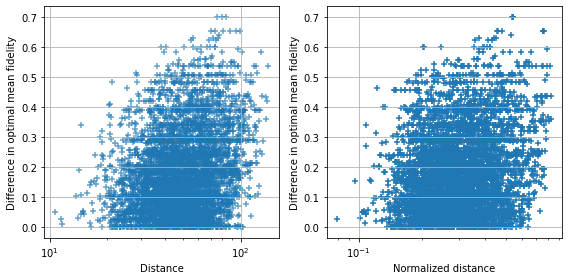

In [39]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))
axes[0].scatter(show_dist, show_fid_diff, marker='+', alpha=0.7)
axes[1].scatter(show_distnorm, show_fid_diff, marker='+')

axes[0].set_xlabel("Distance")
axes[0].set_ylabel("Difference in optimal mean fidelity")
axes[1].set_xlabel("Normalized distance")
axes[1].set_ylabel("Difference in optimal mean fidelity")

axes[0].set_xscale('log')
axes[1].set_xscale('log')

axes[0].grid()
axes[1].grid()
fig.tight_layout()

In [42]:
for qc in qc_list:
    print(qc.draw())
    print('------------------------')

     ┌──────────────┐                ┌──────────────┐          »
q_0: ┤ Rz(theta[0]) ├───────■────────┤ Ry(theta[2]) ├──■───────»
     └──────────────┘┌──────┴───────┐└──────┬───────┘┌─┴─┐┌───┐»
q_1: ────────────────┤ Ry(theta[1]) ├───────■────────┤ Y ├┤ Z ├»
                     └──────────────┘                └───┘└───┘»
«     ┌────────────────┐                                                   »
«q_0: ┤0               ├─────────────────■───────────────────■─────────────»
«     │  Rxx(theta[3]) │┌──────────────┐ │ZZ(theta[5]) ┌───┐ │ZZ(theta[6]) »
«q_1: ┤1               ├┤ Rz(theta[4]) ├─■─────────────┤ X ├─■─────────────»
«     └────────────────┘└──────────────┘               └───┘               »
«     ┌──────────────┐
«q_0: ┤ Ry(theta[7]) ├
«     └──────────────┘
«q_1: ────────────────
«                     
------------------------
     ┌───┐┌───┐┌──────────────┐┌──────────────┐                                »
q_0: ┤ X ├┤ Y ├┤ Rz(theta[0]) ├┤ Ry(theta[1]) ├───────■──────────────